<a href="https://colab.research.google.com/github/mannixp/PDF_Equation/blob/main/Diffusion/Diffusion_1D_Stochastic_BCS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook applies the forward Kolmogorov equation derived in *Craske J. et al. 2024* to the case of 1D scalar diffusion with boundary conditions prescribed by an Ornstein-Ulhenbeck process. The diffusion equation is solved using the open source pseudo-spectral code [Dedalus](https://dedalus-project.org/) (*Burns K.J. et. al. 2020*), while the relevant terms in the forward Kolmogorov equation are estimated using histograms.

**Setup**

This cell checks if Dedalus is installed and performs some other basic setup.


In [ ]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install --no-cache http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()


**Content**

First let's import everything we need to run the rest of the notebook.

In [1]:
import numpy as np
import scipy.stats as ss
import dedalus.public as d3
import logging
import h5py
logger = logging.getLogger(__name__)

import matplotlib.pyplot as plt

**Problem Equations**

The scalar concentration is given by
\begin{equation}
\partial_t Y = \Delta Y, \quad X_1 \in [0,1],
\end{equation}
subject to the boundary conditions prescribed by the stochastic differential equation
\begin{equation}
 dY_t = -a Y_t dt + \sigma dW_t , \quad \text{at} \quad X_1 = 0,1, \\
\end{equation}
where $a,\sigma$ are drift and diffusion coefficients respectively and $W_t$ the Wiener process which evolves independently on each boundary. The steady state solution to the Fokker-Planck equation corresponding to this SDE is given by the normal distribution $\mathcal{N}(0,\frac{\sigma^2}{2a})$. As such this zero mean process is completely characterised by its variance $\sigma^2/2a$ and auto-correlation $\rho(s) = e^{-|s|/T_L}$ such that $T_L = \int_0^{\infty} \rho(s) ds$ is equivalent to the integral time-scale of this process.

Below we write a solver for the SDE as well as for the 1D diffusion problem.

In [2]:
def OU(Y_t,W_t,dt, μ_z,a,σ):
    """
    Ornstein-Ulhenbeck process
    """

    dW_t = np.sqrt(dt) * W_t

    # Euler Maruyama
    return  Y_t + a*(μ_z - Y_t)*dt + σ * dW_t

# Solver
def Solve(N=1000,T=1,Nz=24,a=5,σ=1,W=None):

    zcoord = d3.Coordinate('z')
    dist   = d3.Distributor(zcoord, dtype=np.float64)
    zbasis = d3.ChebyshevT(zcoord, size=Nz, bounds=(0,1),dealias=1)

    # Fields
    Y      = dist.Field(name='Y', bases=zbasis)
    tau_Y1 = dist.Field(name='tau_Y1')
    tau_Y2 = dist.Field(name='tau_Y2')
    g0     = dist.Field(name='g0')
    g1     = dist.Field(name='g1')

    # Substitutions
    dz = lambda A: d3.Differentiate(A, zcoord)
    lift_basis = zbasis.derivative_basis(1)
    lift = lambda A: d3.Lift(A, lift_basis, -1)
    Yz = dz(Y)  + lift(tau_Y1)
    Yzz= dz(Yz) + lift(tau_Y2)

    # Problem
    problem = d3.IVP([Y, tau_Y1, tau_Y2], namespace=locals())
    problem.add_equation("dt(Y) - Yzz = 0")
    problem.add_equation("Y(z=0) = g0")
    problem.add_equation("Y(z=1) = g1")

    # Solver
    solver = problem.build_solver(d3.CNAB1)
    solver.stop_sim_time = T

    # Initial condition
    # z      = dist.local_grid(zbasis)
    # Y['g'] = z;
    
    np.random.seed(42)
    T_vec,dt = np.linspace(0,T,N,retstep=True)
    if W is None:
        W = ss.norm.rvs(loc=0, scale=1, size=(N,2))

    snapshots = solver.evaluator.add_file_handler('snapshots',iter=1)
    snapshots.add_task(Y , layout='g',name='Y'  ,scales=2)
    snapshots.add_task(Yz, layout='g',name='Yz' ,scales=2)

    # Main loop
    logger.info('Starting main loop')
    while solver.proceed:

        n    = solver.iteration

        # Specify the bcs according to OU process
        Yt_z0    = Y(z=0).evaluate()['g'][0];
        g0['g'] = OU(Y_t = Yt_z0, W_t=W[n,0],dt=dt,μ_z=0,a=a,σ=σ)

        Yt_z1    = Y(z=1).evaluate()['g'][0]
        g1['g'] = OU(Y_t = Yt_z1, W_t=W[n,1],dt=dt,μ_z=0,a=a,σ=σ)

        solver.step(dt)

    return None

Setting $a=5,\sigma=1$ we use the solvers to generate a space time plot of the concentration field starting from $Y_0 = 0$ which for vanishing variance $\sigma$ would be the analytical solution to this problem.

2024-05-20 13:50:44,346 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+01/s
2024-05-20 13:50:44,348 __main__ 0/1 INFO :: Starting main loop
2024-05-20 13:50:52,467 solvers 0/1 INFO :: Simulation stop time reached.


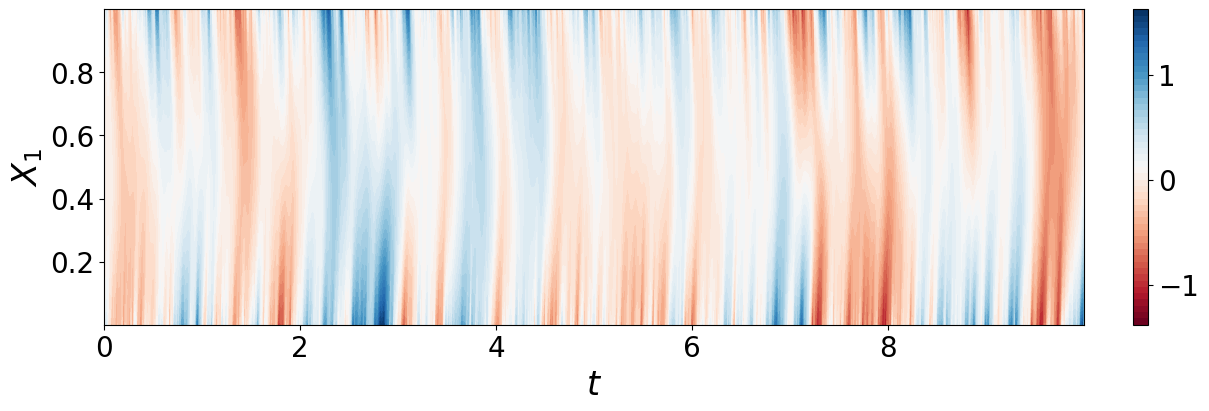

In [4]:
Solve(N=2000,T=10,Nz=24,a=5,σ=1)

# Data loading
file   = h5py.File('snapshots/snapshots_s1.h5', mode='r')

# Data (t,X_1)
Y_vec  = file['tasks/Y' ][:,:]
X1_vec = file['tasks/Y'].dims[1][0][:]
t_vec  = file['tasks/Y'].dims[0][0][:]

from matplotlib import ticker

fig = plt.figure(figsize=(12,4),layout='constrained')
plt.contourf(t_vec,X1_vec,Y_vec.T,levels=50,cmap='RdBu')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20) 
tick_locator = ticker.MaxNLocator(nbins=3)
cbar.locator = tick_locator
cbar.update_ticks()

plt.xlabel(r'$t$',fontsize=24)
plt.ylabel(r'$X_1$',fontsize=24)
plt.tick_params(axis='both', labelsize=20)
plt.show()

The forward Kolmogorov equation describing the *global scalar concentration* is given by
\begin{equation}
\frac{\partial }{ \partial t} f_Y = -\frac{\partial}{ \partial y} \left( \mathbb{D}^{(1)} f_Y \right) + \frac{\partial^2 }{ \partial y^2} \left( \mathbb{D}^{(2)} f_Y \right),
\end{equation}
where
\begin{equation}
\mathbb{D}^{(1)} = 2 \mathbb{E}_{Y_t|\partial \Omega}[ \boldsymbol{n} \cdot \nabla Y_t ] \frac{f_{Y|\partial \Omega }}{f_Y}, \quad\quad \mathbb{D}^{(2)} = \mathbb{E}_{Y_t}[-|\nabla Y_t|^2].
\end{equation}
Here $f_{Y|\partial\Omega}$ corresponds to the density of $Y_t$ when it is sampled from the boundary $\partial \Omega$ while $f_Y(y;t)$ is the global probability density . This density describes the probability of finding a scalar concentration $y$ at a time $t$ in the interval $X_1 \in [0,1]$. Given however that we are forcing the system by a stationary stochastic process we expect both $f_Y$ and $f_{Y|\partial\Omega}$ to be independent of time.

As our system is stochastic we must employ a Monte-Carlo approach in order to estimate the terms in this equation. That is we must time integrate the diffusion problem with different realisations of the Ornstein-Ulhenbeck process, and then average over the ensemble of sample paths generated by each run. This is performed below by integrating 250 realisations from $t=0 \to 5$. 


*Note: This takes about 5 minutes to run*

In [7]:
def Data():

  # Data loading
  file   = h5py.File('snapshots/snapshots_s1.h5', mode='r')

  # Interpolate the data (t,z) from a Chebyshev grid onto a uniform grid
  Y_cheb  = file['tasks/Y' ][:,:]
  Yz_cheb = file['tasks/Yz'][:,:]
  z_cheb  = file['tasks/Y'].dims[1][0][:]
  times   = file['tasks/Y'].dims[0][0][:]

  dz_cheb = z_cheb[1]-z_cheb[0];
  z_data  = np.arange(0,1,dz_cheb);
  s       = (len(times),len(z_data));
  Y_data  = np.zeros(s)
  Yz_data = np.zeros(s)
  for i,t in enumerate(times):
    Y_data[i,:] = np.interp(z_data, z_cheb, Y_cheb[i,:] )
    Yz_data[i,:]= np.interp(z_data, z_cheb, Yz_cheb[i,:])

  return times, z_data,Y_data,Yz_data;

In [ ]:
root = logging.root
for h in root.handlers:
    h.setLevel("WARNING"); 
    
# Generate independent increments
Nz    =24
T     =5 
N     =1000
Paths =250

Solve(N,T,Nz)
times, z_data,Y_data,Yz_data = Data()

pad = 20
stp = (len(times)-pad,Paths)
Y0_Data = np.zeros(stp)
Y1_Data = np.zeros(stp)
Y0zData = np.zeros(stp)
Y1zData = np.zeros(stp)

stzp = (len(times)-pad,len(z_data),Paths)
Y_data   = np.zeros(stzp)
Yz_data  = np.zeros(stzp)
dY2_data = np.zeros(stzp)

W  = ss.norm.rvs(loc=0, scale=1, size=(N,2,Paths))

for n in range(Paths):
    
    Solve(N,T,Nz,W=W[:,:,n])
    
    _,_,Y_n,Yz_n  = Data()
    
    # z-integrated
    Y_data[:,:,n]  =   Y_n[pad:,:] # time,z_data
    Yz_data[:,:,n] =  Yz_n[pad:,:]
    dY2_data[:,:,n]=  Yz_n[pad:,:]**2
    
    # Boundaries
    Y0_Data[:,n] = Y_n[pad:, 0] # time,z=0
    Y1_Data[:,n] = Y_n[pad:,-1]
    Y0zData[:,n] = Yz_n[pad:, 0]
    Y1zData[:,n] = Yz_n[pad:,-1]

    if n%(Paths//5) == 0:
        print('Path = %d'%n,'\n')


*Density*

Using a histogram we first estimate the pdf $f_Y(y)$ by binning over time and the ensemble of realisations. Given therefore that $f_Y(y;t)$ is stationary its time-derivative is not estimated. 

In [9]:
def density(Y_data,Range,N_bins):

  f,y = np.histogram(Y_data[...].flatten(),range=Range,bins=N_bins,density=True); 
  y   = 0.5*(y[1:] + y[:-1]);

  return f,y

*Diffusion Coefficient*

We then compute the diffusion coefficient
\begin{equation}
\mathbb{D}^{(2)} \equiv \mathbb{E}_{Y}[-|\nabla Y_t|^2] = - \int \phi \frac{ f_{\Phi Y }(\phi,y) }{f_Y(y)} d \phi, \quad \text{where} \quad \Phi = |\nabla Y|^2,
\end{equation}
by using the fact that the conditional expectation can be re-expressed in terms of its joint density. This coefficent is calculated below by estimating the joint density using a histogram by binning over time and the ensemble of realisations.

In [32]:
def diffusion(dY2_data,Y_data,Range,N_bins):

  # Expectation
  # Let Φ = |∇Y|^2 and φ its dummy variable

  Y   = Y_data[...].flatten()
  dY2 = dY2_data[...].flatten()

  f_YΦ,y,φ = np.histogram2d(Y,dY2,range = (Range,(min(dY2),max(dY2))),bins=N_bins,density=True)
  φ = .5*(φ[1:]+φ[:-1]); dφ = φ[1] - φ[0];
  y = .5*(y[1:]+y[:-1]); dy = y[1] - y[0];
  f_Y =  np.sum(  f_YΦ,axis=1)*dφ;      # f_Y(y)
  E   = (np.sum(φ*f_YΦ,axis=1)*dφ)/f_Y; # E{Φ|Y} = int_φ f_Φ|Y(φ|y)*φ dφ
  D2  = -E

  return D2

*Drift coefficient*

Finally we calculate the drift coefficient by using the fact that the product of the density $f_{Y|\partial \Omega }$ and the conditional average of the gradient of $Y_t$ restricted to the boundary $\mathbb{E}_{Y_t|\partial \Omega}[ \boldsymbol{n} \cdot \nabla Y_t ]$ can be expressed as
\begin{equation}
\mathbb{D}^{(1)} = 2\mathbb{E}_{Y_t|\partial \Omega}[ \boldsymbol{n} \cdot \nabla Y_t ] f_{Y|\partial \Omega } = 2 \int \phi f_{\boldsymbol{n} \cdot \nabla Y_t,Y|\partial \Omega}(\phi, y) d\phi. 
\end{equation}
We calculate this term by estimating the joint density $f_{\boldsymbol{n} \cdot \nabla Y_t,Y|\partial \Omega}(\phi, y)$ using a histogram (by binning over time and the ensemble of realisations) which can then be used to compute the previous integral as implemented below.

In [33]:
nz_minus = -1 # at z=0
nz_plus  =  1 # at z=1

def Expectation(Y,dY,y,N_bins):
    
    f_YΦ,_,φ = np.histogram2d(Y,dY,range = ((min(y),max(y)),(min(dY),max(dY))),bins=N_bins,density=True) # n (-3)
    φ   = .5*(φ[1:]+φ[:-1]); 
    dφ  = φ[1] - φ[0];
    E   = np.sum(φ*f_YΦ,axis=1)*dφ # E{Φ|Y=y}*f(y) = int_φ f_ΦY(φ,y)*φ dφ where φ = n.∇Y_t

    return E

def drift(f,y, Y0,Y1,Yz0,Yz1,N_bins):

  Y_t   = np.hstack( ( Y1[...].flatten(),   Y0[...].flatten())  )
  nDY_t = np.hstack( (nz_plus*Yz1[...].flatten(), nz_minus*Yz0[...].flatten())  )
  return 2*Expectation(Y_t,nDY_t,y,N_bins)/f

**Results**

We first generate the joint PDF $f_{\boldsymbol{n} \cdot \nabla Y_t,Y|\partial \Omega}(\phi, y)$ by averaging over realisations and time. 

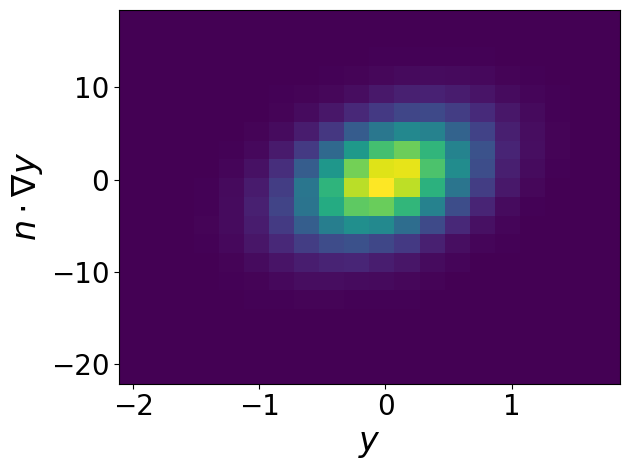

In [34]:
fig = plt.figure()

Y_DATA = np.concatenate((Y0_Data[...].flatten(),Y1_Data[...].flatten()))
dY_DATA= np.concatenate((nz_minus*Y0zData[...].flatten(),nz_plus*Y1zData[...].flatten()))

plt.hist2d(x=Y0_Data[...].flatten(), y=nz_minus*Y0zData[...].flatten(),bins = 20)
plt.xlabel(r'$y$',fontsize=24)
plt.ylabel(r'$n \cdot \nabla y$',fontsize=24)

plt.tick_params(axis='both', labelsize=20)
plt.tight_layout()
plt.show()

Using the previous functions we then generate the density, drift and diffusion coefficients $f_Y, \mathbb{D}^{(1)}, \mathbb{D}^{(2)}$ from the ensemble of realisations. These are plotted below along with a comparison of the terms in the right hand side of the foward Kolmogorov equation. We restrict the range of the figure's axes as outliers have a low probability and are thus difficult to converge. Increasing the number of bins improves the agreement between the drift $\mathbb{D}^{(1)}f_Y$ and diffusion $\partial_y (\mathbb{D}^{(2)}f_Y)$ terms, but this also increases the variance it their trends. For this reason we have applied a Gaussian filter to the data in frame (c) when making this comparison. 

In [50]:
def Plot_Terms(y,f,D1,D2):

  fig, axs = plt.subplots(2, 2, layout='constrained',figsize=(12,6))

  # ~~~~~~~~~ (a) ~~~~~~~
  axs[0,0].plot(y,D1,'k', linewidth=2,label=r'$\mathbb{D}^{(1)}(y)$')

  # ~~~~~~~~~ (b) ~~~~~~~
  axs[0,1].plot(y,D2,'k', linewidth=2,label=r'$\mathbb{D}^{(2)}(y)$')

  # ~~~~~~~~~ (c) ~~~~~~~

  N = len(y)
  D = np.zeros((N,N))
  for i in range(N):
    
    if i < N - 1:
      D[i,i+1] = 1
    if i > 0:
      D[i,i-1] =-1 
  
  D*=.5/(y[1]-y[0])

  from scipy.ndimage import gaussian_filter1d

  axs[1,0].plot(y,gaussian_filter1d(D1*f,sigma=2),'r:', linewidth=2,label=r'$\mathbb{D}^{(1)} f_Y$')
  axs[1,0].plot(y,D@(gaussian_filter1d(D2*f,sigma=2)),'b--', linewidth=2,label=r'$\partial_y \left( \mathbb{D}^{(2)} f_Y \right)$')

  axs[1,0].set_xlabel(r'$y$',fontsize=20)

  # ~~~~~~~~~ (d) ~~~~~~~
  axs[1,1].plot(y,f,'r', linewidth=2,label=r'$f_Y(y)$')
  axs[1,1].fill_between(x=y,y1=f,color= "r",alpha= 0.2)
  axs[1,1].set_ylim([0,1.1*max(f)])

  axs[1,1].set_xlabel(r'$y$',fontsize=20)

  axs[0,0].annotate(r'(a)', xy=(0.05,0.85), xycoords='axes fraction',fontsize=24)
  axs[0,1].annotate(r'(b)', xy=(0.05,0.85), xycoords='axes fraction',fontsize=24)
  axs[1,0].annotate(r'(c)', xy=(0.05,0.85), xycoords='axes fraction',fontsize=24)
  axs[1,1].annotate(r'(d)', xy=(0.05,0.85), xycoords='axes fraction',fontsize=24)

  for ax in [axs[0,0],axs[1,0],axs[0,1],axs[1,1]]:
    ax.set_xlim([min(y),max(y)])
    ax.legend(loc=8,fontsize=20)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)

  axs[1,0].legend(loc=4,fontsize=20)

  plt.savefig('1D_Diffusion.png',dpi=200)
  plt.show()

  return None;

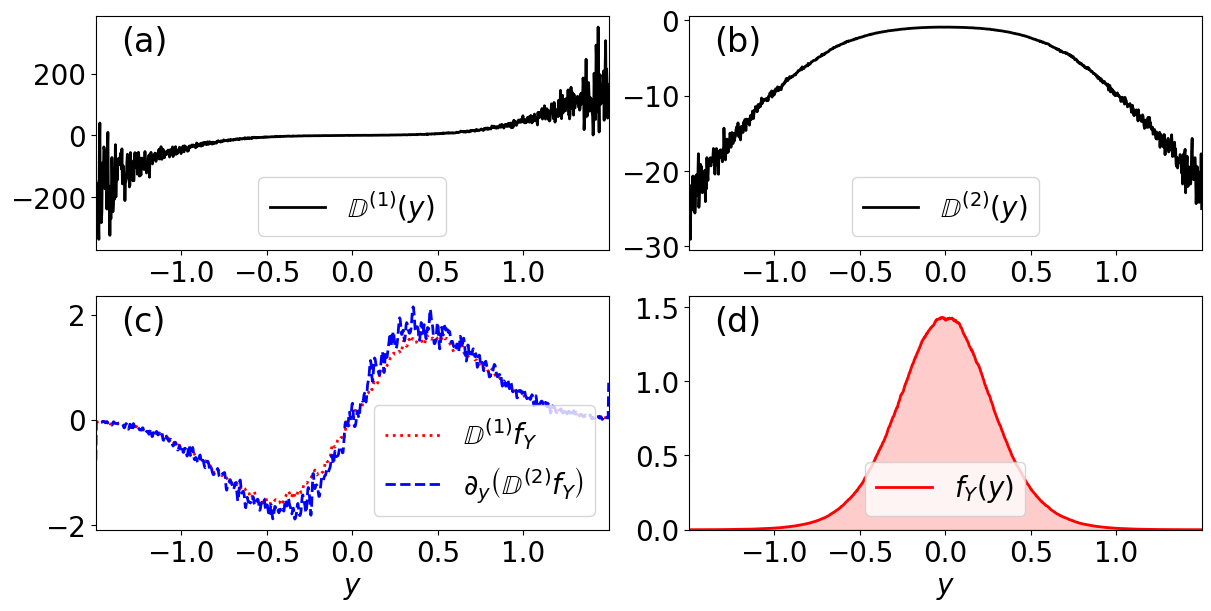

In [51]:

Range = (-1.5,1.5)
N_bins=1024

# Estimate the terms
f,y = density(Y_data,Range,N_bins)
D2  = diffusion(dY2_data,Y_data,Range,N_bins)
D1  = drift(f,y, Y0_Data,Y1_Data,Y0zData,Y1zData, N_bins)

Plot_Terms(y,f,D1,D2)